In [1]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as met

# ETL library
from ETL import ETL

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, pacf, acf

# ARIMA and SARIMAX models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Statsmodels API
import statsmodels.api as sm


# New York Analysis

In [2]:
df = pd.read_csv('dataset/2012.csv')

In [3]:
filtered_df = df[['FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN', 'DEST', 'DISTANCE', 'AIR_TIME']]

print(filtered_df.head())


      FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
0  2012-01-01      -13.0      -13.0    BMI  ORD     116.0      37.0
1  2012-01-01       -5.0      -16.0    ORD  BMI     116.0      23.0
2  2012-01-01      -10.0      -20.0    SGF  ORD     438.0      75.0
3  2012-01-01       -6.0      -15.0    ORD  DBQ     147.0      31.0
4  2012-01-01       15.0        9.0    ORD  RIC     642.0      86.0


In [4]:
ny_airports = ['LAX']
filtered_df['FL_DATE'] = pd.to_datetime(filtered_df['FL_DATE'])
ny_flights_depatures = filtered_df[
    (filtered_df['ORIGIN'].isin(ny_airports)) & 
    (filtered_df['AIR_TIME'].notna())
]
ny_flights_arrivals = filtered_df[
    (filtered_df['DEST'].isin(ny_airports)) & 
    (filtered_df['AIR_TIME'].notna())
]

print(ny_flights_depatures.head())
print(ny_flights_arrivals.head())

C:\Users\dswal\AppData\Local\Temp\ipykernel_23008\2447999021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['FL_DATE'] = pd.to_datetime(filtered_df['FL_DATE'])


       FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
318 2012-01-01        1.0        0.0    LAX  SBA      89.0      21.0
322 2012-01-01       15.0       22.0    LAX  YUM     237.0      54.0
336 2012-01-01       -3.0        3.0    LAX  SAT    1210.0     154.0
340 2012-01-01      147.0      141.0    LAX  COS     833.0     117.0
341 2012-01-01       -2.0       -7.0    LAX  FAT     209.0      34.0
       FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
317 2012-01-01       14.0       10.0    BOI  LAX     674.0     108.0
337 2012-01-01       -8.0      -12.0    SMF  LAX     373.0      66.0
346 2012-01-01      -12.0       -3.0    SMF  LAX     373.0      62.0
349 2012-01-01       -8.0        7.0    PHX  LAX     370.0      58.0
361 2012-01-01       -7.0      -15.0    PSP  LAX     110.0      25.0


In [5]:
# identifichiamo la settimana

daily_departures = ny_flights_depatures.groupby('FL_DATE').size().reset_index(name='DEPARTURES')
daily_arrivals = ny_flights_arrivals.groupby('FL_DATE').size().reset_index(name='ARRIVALS')
daily_traffic = pd.merge(daily_departures, daily_arrivals, on='FL_DATE', how='outer').fillna(0)

daily_traffic['TOTAL_TRAFFIC'] = daily_traffic['DEPARTURES'] + daily_traffic['ARRIVALS']

print(daily_traffic.head())
print(ny_flights_depatures.head())
print(ny_flights_arrivals.head())



     FL_DATE  DEPARTURES  ARRIVALS  TOTAL_TRAFFIC
0 2012-01-01         547       540           1087
1 2012-01-02         641       631           1272
2 2012-01-03         580       578           1158
3 2012-01-04         571       567           1138
4 2012-01-05         608       612           1220
       FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
318 2012-01-01        1.0        0.0    LAX  SBA      89.0      21.0
322 2012-01-01       15.0       22.0    LAX  YUM     237.0      54.0
336 2012-01-01       -3.0        3.0    LAX  SAT    1210.0     154.0
340 2012-01-01      147.0      141.0    LAX  COS     833.0     117.0
341 2012-01-01       -2.0       -7.0    LAX  FAT     209.0      34.0
       FL_DATE  DEP_DELAY  ARR_DELAY ORIGIN DEST  DISTANCE  AIR_TIME
317 2012-01-01       14.0       10.0    BOI  LAX     674.0     108.0
337 2012-01-01       -8.0      -12.0    SMF  LAX     373.0      66.0
346 2012-01-01      -12.0       -3.0    SMF  LAX     373.0      62.0
349 2012-0

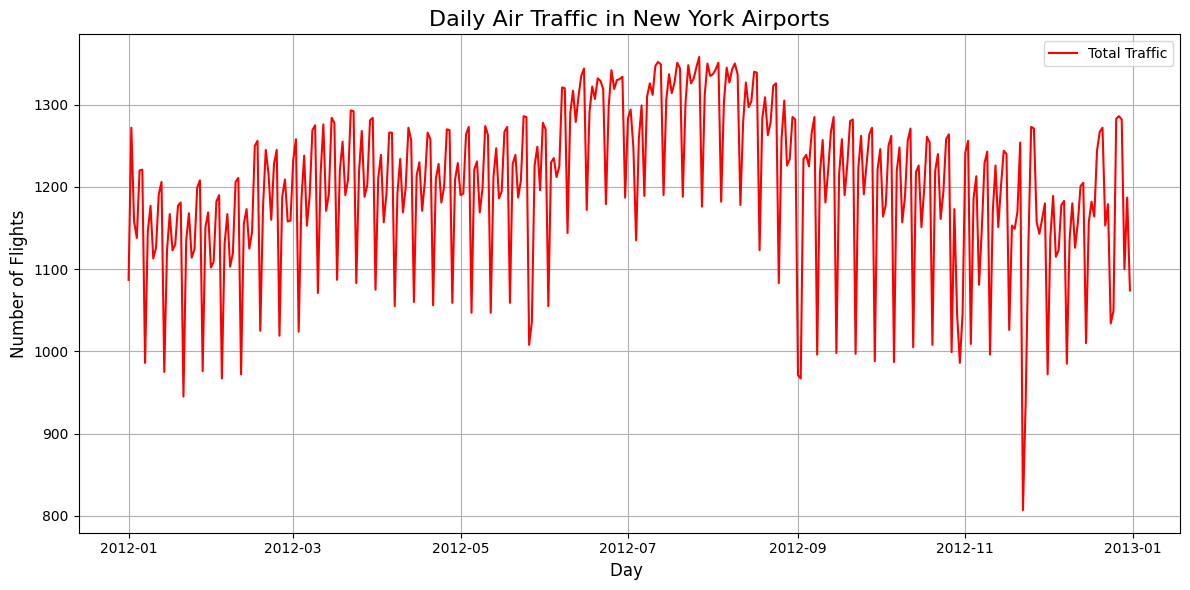

In [6]:
plt.figure(figsize=(12, 6))
#plt.plot(daily_traffic['FL_DATE'], daily_traffic['DEPARTURES'], marker='o', linestyle='-', color='b', label='Departures')
#plt.plot(daily_traffic['FL_DATE'], daily_traffic['ARRIVALS'], marker='o', linestyle='--', color='g', label='Arrivals')
plt.plot(daily_traffic['FL_DATE'], daily_traffic['TOTAL_TRAFFIC'], linestyle='-', color='r', label='Total Traffic')
plt.title('Daily Air Traffic in New York Airports', fontsize=16)
plt.xlabel('Day ', fontsize=12)
plt.ylabel('Number of Flights', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Temporal Series

In [2]:
df = pd.read_csv('dataset/best_route_flights.csv')

In [3]:
df = ETL(df)

In [4]:
df['OP_CARRIER'].value_counts()

OP_CARRIER
UA    46929
WN    34735
VX    20157
AA    16997
OO    14545
DL     9608
AS     3309
CO        8
Name: count, dtype: int64

In [5]:
df = df[(df['CANCELLED'] != 1) & (df['DIVERTED'] != 1) & (df['OP_CARRIER'] == 'UA')]
df = df[['FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN', 'DEST', 'DISTANCE', 'AIR_TIME']]

df.head()


,FL_DATE,DEP_DELAY,ARR_DELAY,ORIGIN,DEST,DISTANCE,AIR_TIME
0,2009-01-01,-2.0,-20.0,SFO,LAX,337.0,56.0
1,2009-01-01,-8.0,-28.0,SFO,LAX,337.0,54.0
2,2009-01-01,5.0,-8.0,SFO,LAX,337.0,55.0
3,2009-01-01,13.0,-7.0,SFO,LAX,337.0,53.0
4,2009-01-01,-6.0,-29.0,SFO,LAX,337.0,53.0


In [6]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['FL_DATE'] = df['FL_DATE'].dt.normalize()

daily_analysis = df.groupby("FL_DATE").agg(
    AVG_DEP_DELAY=("DEP_DELAY", "mean"),
    AVG_ARR_DELAY=("ARR_DELAY", "mean"),
    AVG_AIR_TIME=("AIR_TIME", "mean"), 
    NUM_FLIGHTS=("FL_DATE", "size")
).fillna(0)

# Applicare una media mobile esponenziale
daily_analysis['EMA_ARR_DELAY'] = daily_analysis['AVG_ARR_DELAY'].ewm(span=30, adjust=False).mean()

daily_analysis


,AVG_DEP_DELAY,AVG_ARR_DELAY,AVG_AIR_TIME,NUM_FLIGHTS,EMA_ARR_DELAY
FL_DATE,,,,,
2009-01-01,-0.727273,-14.545455,54.454545,11,-14.545455
2009-01-02,26.230769,17.000000,54.153846,13,-12.510264
2009-01-03,0.083333,-10.000000,56.333333,12,-12.348311
2009-01-04,10.125000,-6.437500,53.375000,16,-11.966969
2009-01-05,19.266667,7.600000,50.533333,15,-10.704584
...,...,...,...,...,...
2018-12-27,6.500000,4.666667,52.000000,12,12.129143
2018-12-28,12.833333,10.166667,54.833333,12,12.002531
2018-12-29,5.000000,-0.333333,55.000000,9,11.206669


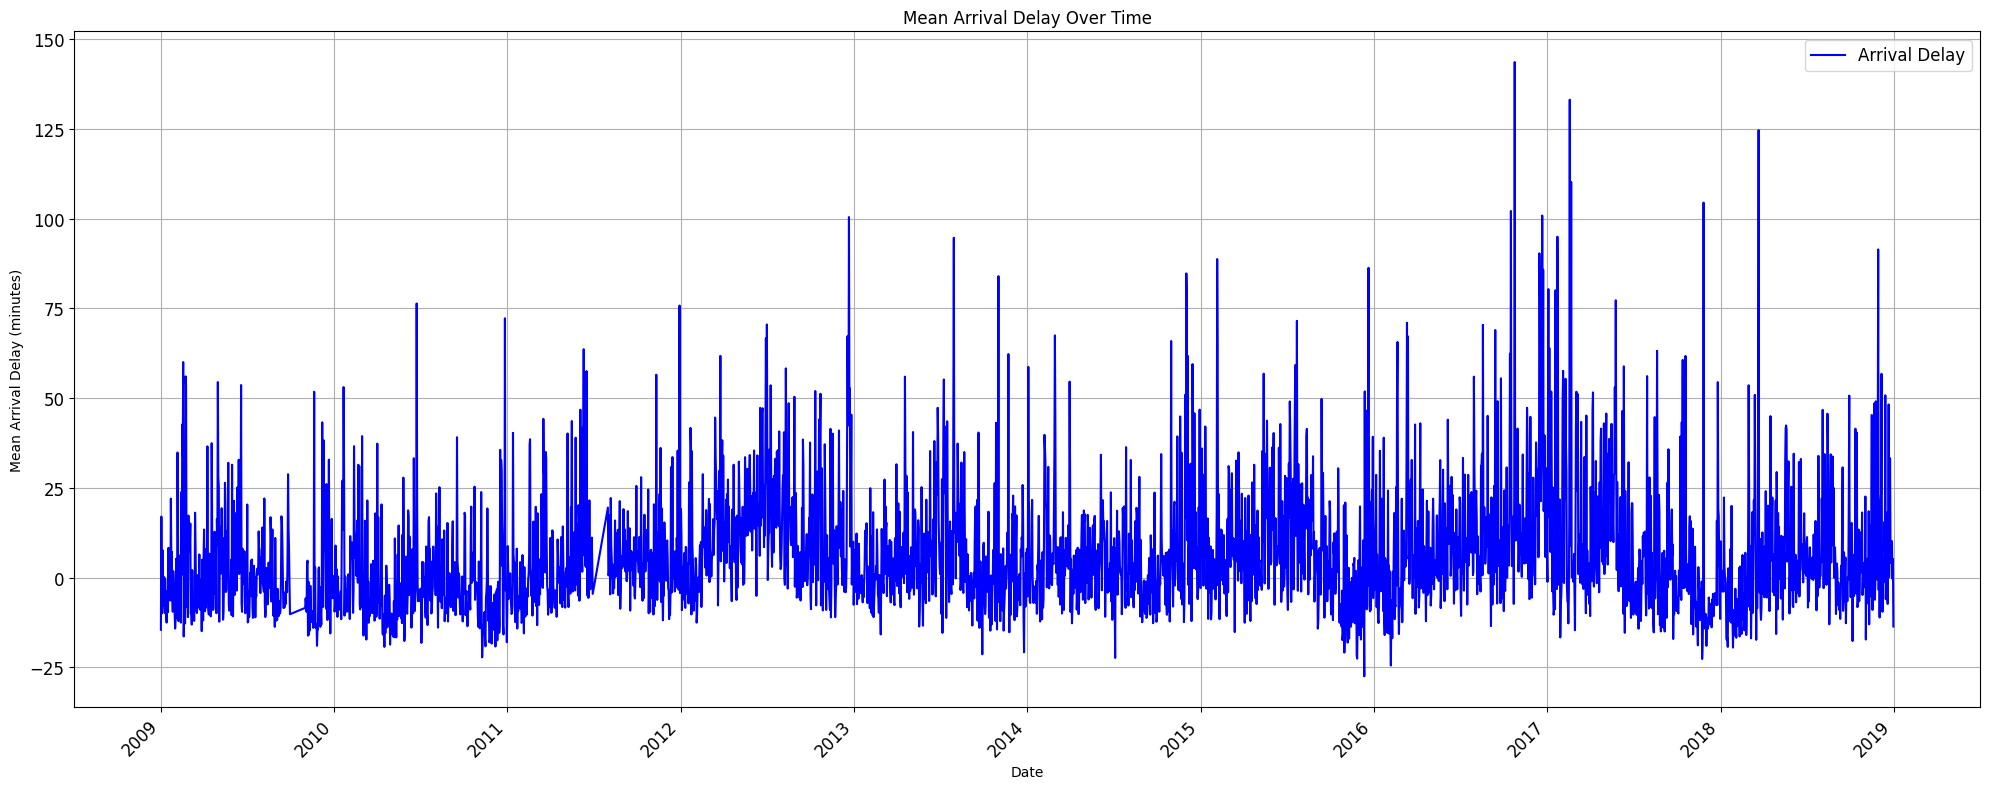

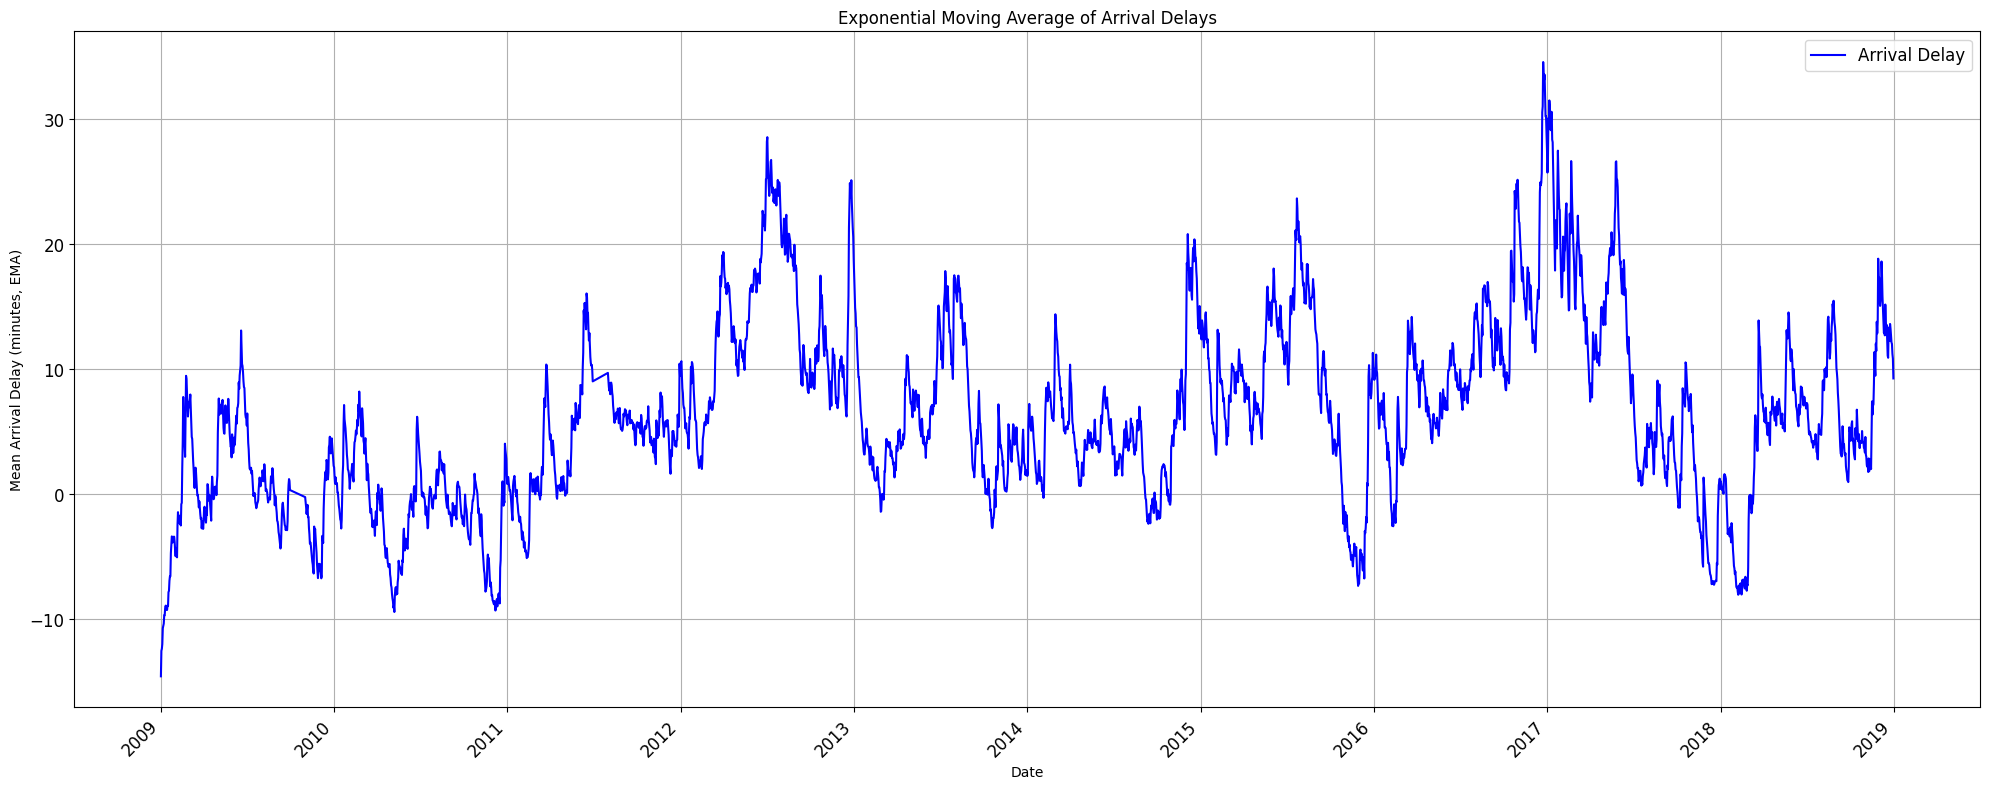

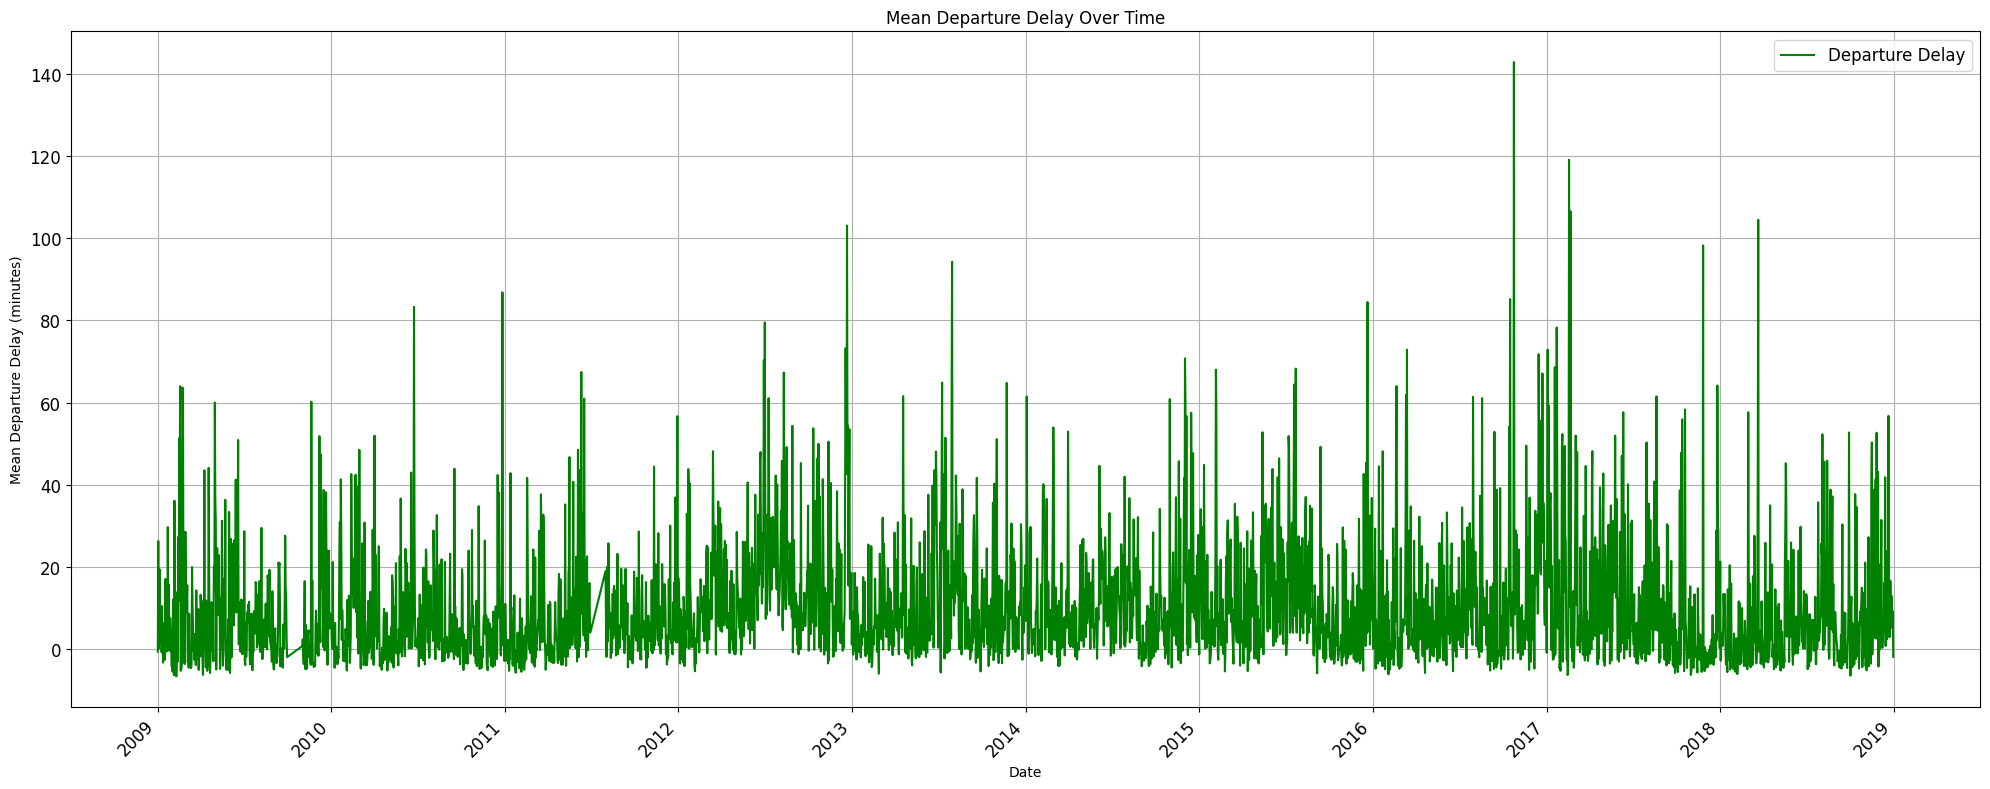

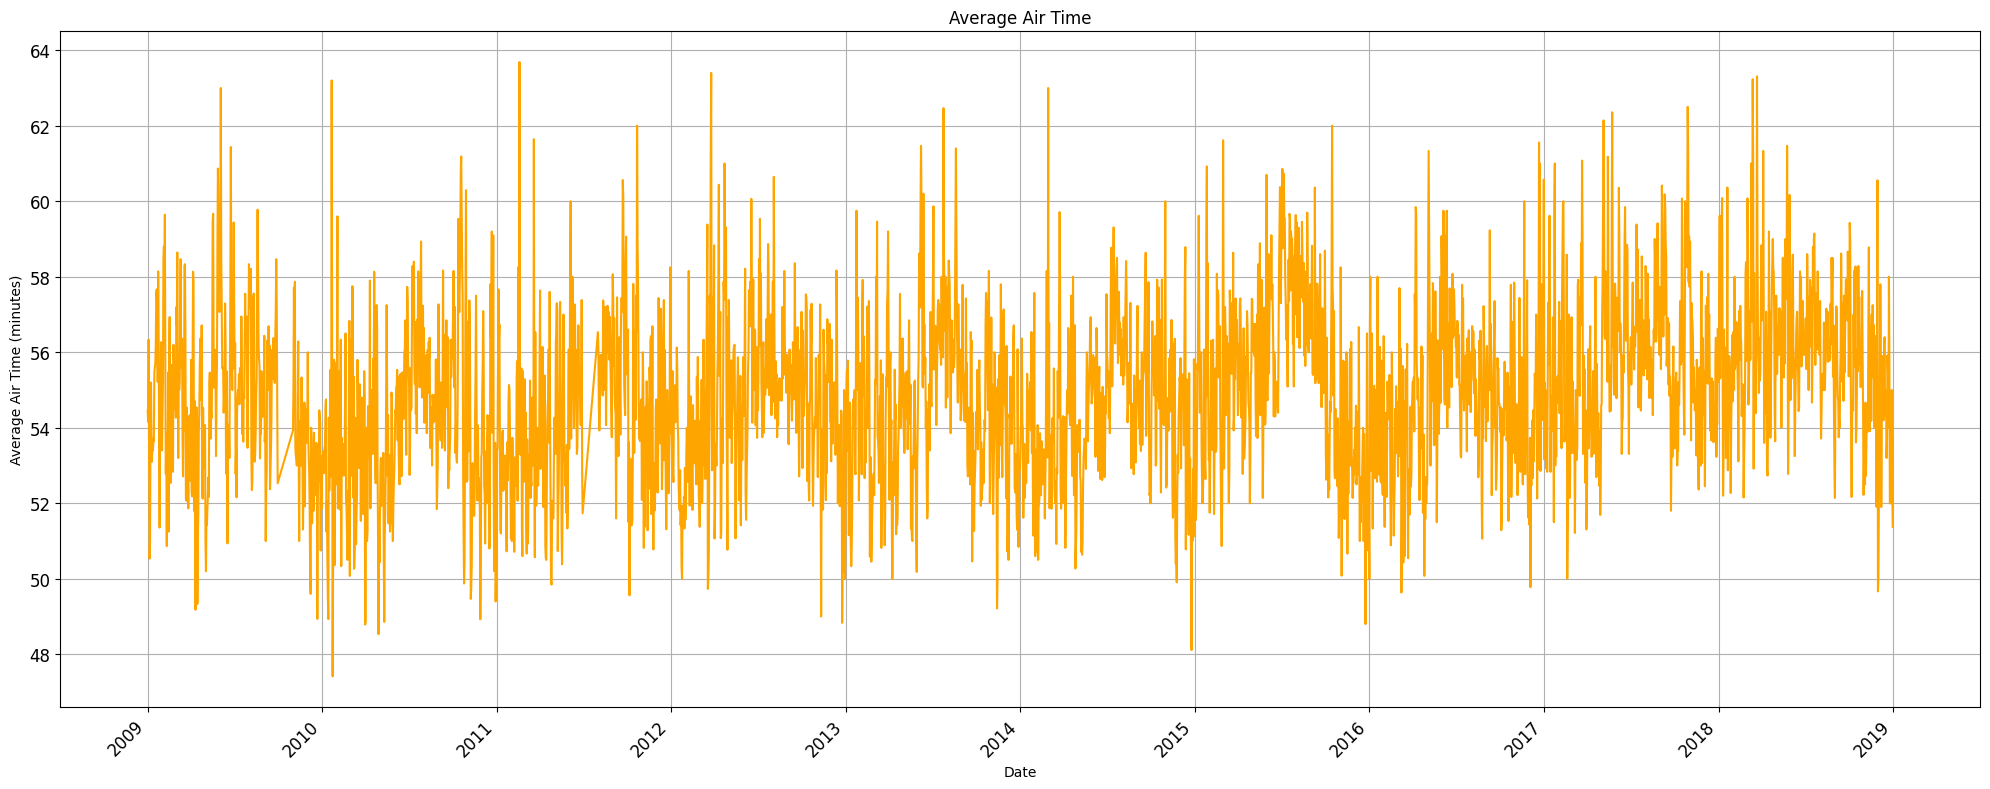

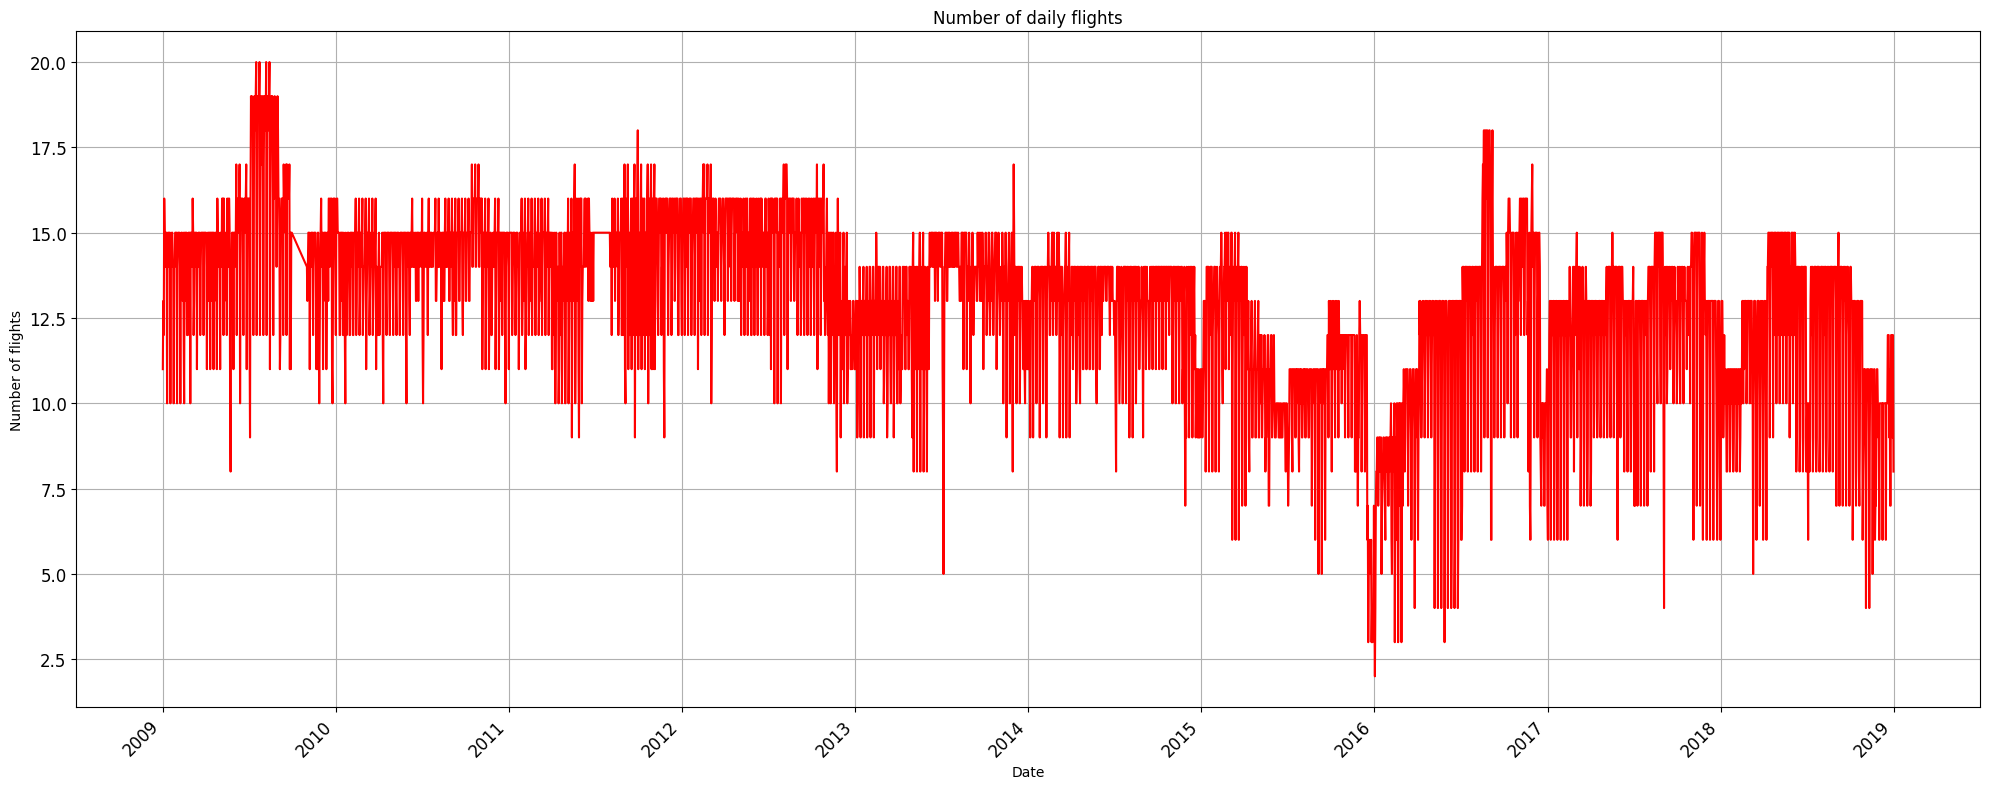

In [69]:
# Grafico del ritardo totale nel tempo (partenza e arrivo)
daily_analysis["AVG_ARR_DELAY"].plot(
    figsize=(20, 8), linestyle='-', color='b', 
    title="Mean Arrival Delay Over Time", grid=True, 
    xlabel="Date", ylabel="Mean Arrival Delay (minutes)", label="Arrival Delay"
)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

daily_analysis["EMA_ARR_DELAY"].plot(
    figsize=(20, 8), linestyle='-', color='b', 
    title="Exponential Moving Average of Arrival Delays", grid=True, 
    xlabel="Date", ylabel="Mean Arrival Delay (minutes, EMA)", label="Arrival Delay"
)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Grafico del ritardo totale in partenza nel tempo
daily_analysis["AVG_DEP_DELAY"].plot(
    figsize=(20, 8), linestyle='-', color='g', 
    title="Mean Departure Delay Over Time", grid=True, 
    xlabel="Date", ylabel="Mean Departure Delay (minutes)", label="Departure Delay"
)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Grafico della media del tempo di volo
daily_analysis["AVG_AIR_TIME"].plot(
    figsize=(20, 8), color='orange', 
    title="Average Air Time", grid=True, 
    xlabel="Date", ylabel="Average Air Time (minutes)"
)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Grafico della media del tempo di volo
daily_analysis["NUM_FLIGHTS"].plot(
    figsize=(20, 8), color='red', 
    title="Number of daily flights", grid=True, 
    xlabel="Date", ylabel="Number of flights"
)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()




In [7]:
# Creare un range di date che va dalla prima alla ultima data
date_range = pd.date_range(start=daily_analysis.index.min(), end=daily_analysis.index.max(), freq='D')

# Confrontare il range con l'indice delle date nel dataframe
missing_dates = date_range.difference(daily_analysis.index)

# Visualizzare le date mancanti
print(missing_dates)

DatetimeIndex(['2009-10-01', '2009-10-02', '2009-10-03', '2009-10-04',
               '2009-10-05', '2009-10-06', '2009-10-07', '2009-10-08',
               '2009-10-09', '2009-10-10', '2009-10-11', '2009-10-12',
               '2009-10-13', '2009-10-14', '2009-10-15', '2009-10-16',
               '2009-10-17', '2009-10-18', '2009-10-19', '2009-10-20',
               '2009-10-21', '2009-10-22', '2009-10-23', '2009-10-24',
               '2009-10-25', '2009-10-26', '2009-10-27', '2009-10-28',
               '2009-10-29', '2009-10-30', '2009-10-31', '2011-07-01',
               '2011-07-02', '2011-07-03', '2011-07-04', '2011-07-05',
               '2011-07-06', '2011-07-07', '2011-07-08', '2011-07-09',
               '2011-07-10', '2011-07-11', '2011-07-12', '2011-07-13',
               '2011-07-14', '2011-07-15', '2011-07-16', '2011-07-17',
               '2011-07-18', '2011-07-19', '2011-07-20', '2011-07-21',
               '2011-07-22', '2011-07-23', '2011-07-24', '2011-07-25',
      

In [8]:
# Creare un nuovo dataframe con tutte le date
all_dates_df = pd.DataFrame(index=date_range)

# Unire il dataframe con daily_analysis per includere anche le date mancanti
daily_analysis_full = all_dates_df.join(daily_analysis, how='left')

# Interpolare i valori mancanti in base al tempo
daily_analysis_full_interpolated = daily_analysis_full.interpolate(method='time')

# Visualizzare il risultato
print(daily_analysis_full_interpolated)

            AVG_DEP_DELAY  AVG_ARR_DELAY  AVG_AIR_TIME  NUM_FLIGHTS  \
2009-01-01      -0.727273     -14.545455     54.454545         11.0   
2009-01-02      26.230769      17.000000     54.153846         13.0   
2009-01-03       0.083333     -10.000000     56.333333         12.0   
2009-01-04      10.125000      -6.437500     53.375000         16.0   
2009-01-05      19.266667       7.600000     50.533333         15.0   
...                   ...            ...           ...          ...   
2018-12-27       6.500000       4.666667     52.000000         12.0   
2018-12-28      12.833333      10.166667     54.833333         12.0   
2018-12-29       5.000000      -0.333333     55.000000          9.0   
2018-12-30       9.083333       5.250000     52.333333         12.0   
2018-12-31      -2.000000     -13.625000     51.375000          8.0   

            EMA_ARR_DELAY  
2009-01-01     -14.545455  
2009-01-02     -12.510264  
2009-01-03     -12.348311  
2009-01-04     -11.966969  
2009-01

## Arrival Delay

<Axes: >

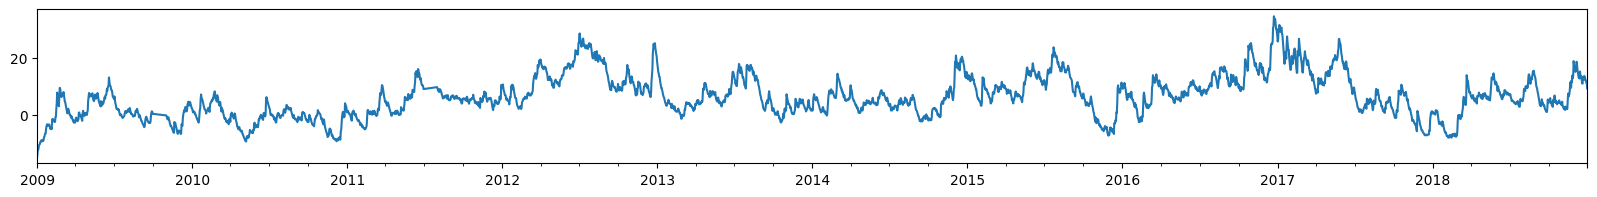

In [9]:
daily_analysis_arr = daily_analysis_full_interpolated['EMA_ARR_DELAY']
# Creare un intervallo completo di date che copra tutte le date nel dataset
full_index = pd.date_range(start=daily_analysis.index[0], end=daily_analysis.index[-1], freq='D')

# Allineare daily_analysis_arr con il nuovo indice completo
daily_analysis_arr = daily_analysis['EMA_ARR_DELAY'].reindex(full_index)

# Gestire i valori mancanti (NaN) con interpolazione, propagazione, o riempiendo con 0
daily_analysis_arr.interpolate(method='time', inplace=True)  # Interpolazione lineare basata sul tempo

daily_analysis_arr.plot(figsize=(20, 2))


### Stazionarietà

In [73]:
X = daily_analysis_arr.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.718094
p-value: 0.000078
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### Stagionalità, trend e residui

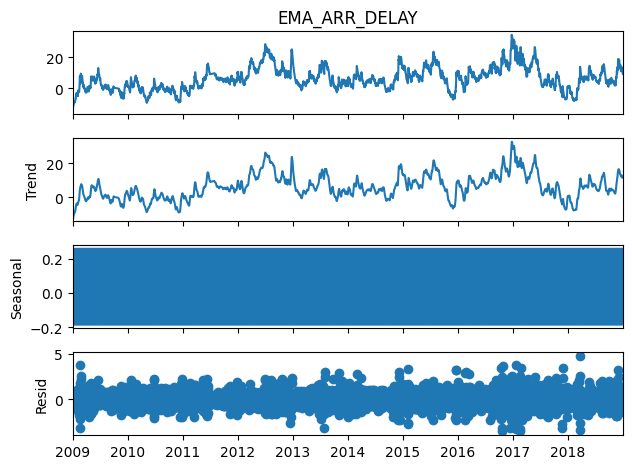

In [75]:
# Perform seasonal decomposition
dec2 = seasonal_decompose(daily_analysis_arr.asfreq('D').interpolate('linear'), model='additive')
dec2.plot()
plt.show()


In [76]:
# Componenti della decomposizione
trend_component = dec2.trend
seasonal_component = dec2.seasonal
residual_component = dec2.resid

# Stampa o salva le informazioni estratte
print("Trend:", trend_component)
print("Seasonal:", seasonal_component)
print("Residual:", residual_component)

Trend: 2009-01-01          NaN
2009-01-02          NaN
2009-01-03          NaN
2009-01-04   -11.848038
2009-01-05   -11.150705
                ...    
2018-12-27    12.233404
2018-12-28    11.611971
2018-12-29          NaN
2018-12-30          NaN
2018-12-31          NaN
Freq: D, Name: trend, Length: 3652, dtype: float64
Seasonal: 2009-01-01   -0.003431
2009-01-02    0.259401
2009-01-03   -0.096926
2009-01-04    0.022296
2009-01-05    0.121568
                ...   
2018-12-27   -0.003431
2018-12-28    0.259401
2018-12-29   -0.096926
2018-12-30    0.022296
2018-12-31    0.121568
Freq: D, Name: seasonal, Length: 3652, dtype: float64
Residual: 2009-01-01         NaN
2009-01-02         NaN
2009-01-03         NaN
2009-01-04   -0.141227
2009-01-05    0.324553
                ...   
2018-12-27   -0.100831
2018-12-28    0.131159
2018-12-29         NaN
2018-12-30         NaN
2018-12-31         NaN
Freq: D, Name: resid, Length: 3652, dtype: float64


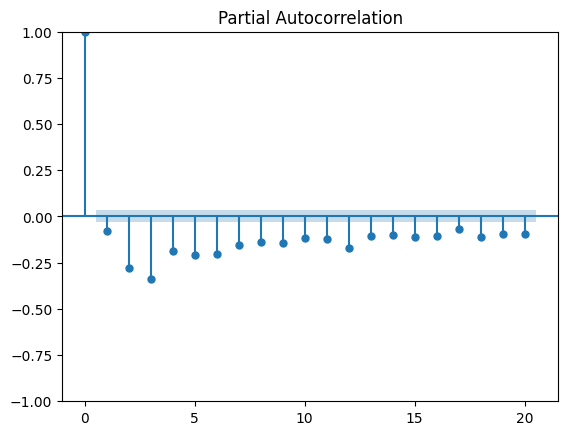

In [80]:
sm.graphics.tsa.plot_pacf(residual_component.diff().dropna(), lags=20, method="ywm")
plt.show()

In [ ]:
# Calcolo delle differenze
diff = residual_component.diff().dropna()

# Calcolo dei valori di PACF per 20 lag
pacf_values = pacf(diff, nlags=20, method="ywm")

# Conta i valori superiori a 0.1 o inferiori a -0.1 (zona di confidenza)
count_above_01 = (pacf_values > 0.1).sum()
count_below_01 = (pacf_values < -0.1).sum()

print(f"Numero di valori PACF superiori a 0.1 nei primi 20 lag: {count_above_01}")
print(f"Numero di valori PACF inferiori a -0.1 nei primi 20 lag: {count_below_01}")

Numero di valori PACF superiori a 0.1 nei primi 20 lag: 1
Numero di valori PACF inferiori a -0.1 nei primi 20 lag: 15


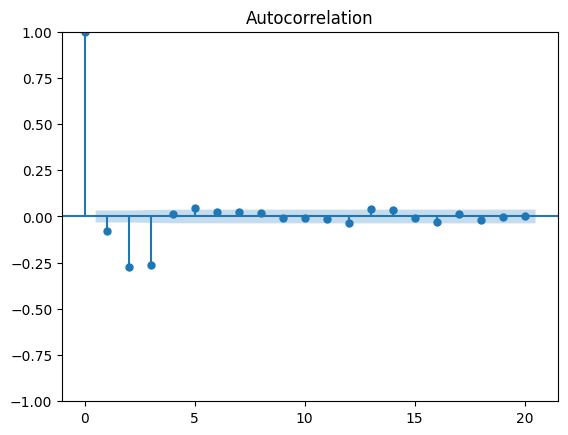

In [82]:
sm.graphics.tsa.plot_acf(residual_component.diff().dropna(), lags=20)
plt.show()

In [ ]:
# Calcolo delle differenze
diff = residual_component.diff().dropna()

# Calcolo dei valori di ACF  per 20 lag
pacf_values = acf(diff, nlags=20)

# Conta i valori superiori a 0.1 o inferiori a -0.1 (zona di confidenza)
count_above_01 = (pacf_values > 0.1).sum()
count_below_01 = (pacf_values < -0.1).sum()

print(f"Numero di valori ACF superiori a 0.1 nei primi 20 lag: {count_above_01}")
print(f"Numero di valori ACF inferiori a -0.1 nei primi 20 lag: {count_below_01}")

Numero di valori ACF superiori a 0.1 nei primi 20 lag: 1
Numero di valori ACF inferiori a -0.1 nei primi 20 lag: 2


### Autocorrelazione Parziale e Autocorrelazione

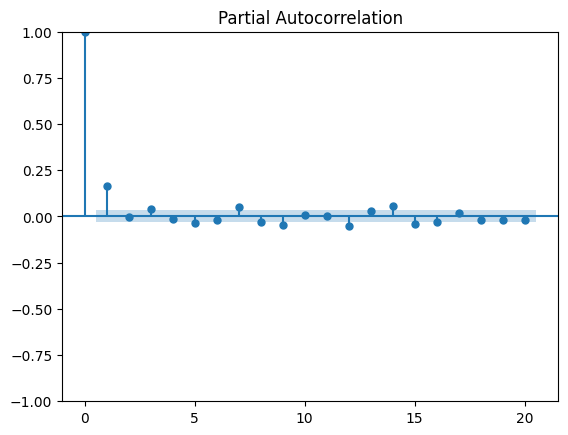

In [ ]:
sm.graphics.tsa.plot_pacf(daily_analysis_arr.diff().dropna(), lags=20, method="ywm")
plt.show()

In [ ]:
# Calcolo delle differenze
diff = daily_analysis_arr.diff().dropna()

# Calcolo dei valori di PACF per 20 lag
pacf_values = pacf(diff, nlags=20, method="ywm")

# Conta i valori superiori a 0.1 o inferiori a -0.1 (zona di confidenza)
count_above_01 = (pacf_values > 0.1).sum()
count_below_01 = (pacf_values < -0.1).sum()

print(f"Numero di valori PACF superiori a 0.1 nei primi 20 lag: {count_above_01}")
print(f"Numero di valori PACF inferiori a -0.1 nei primi 20 lag: {count_below_01}")

Numero di valori PACF superiori a 0.1 nei primi 20 lag: 2
Numero di valori PACF inferiori a -0.1 nei primi 20 lag: 0


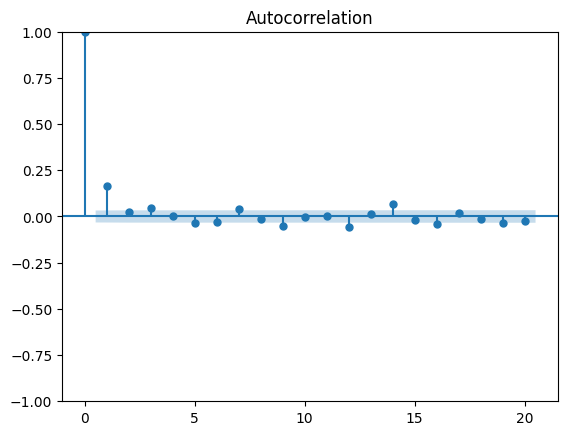

In [83]:
sm.graphics.tsa.plot_acf(daily_analysis_arr.diff().dropna(), lags=20)
plt.show()

In [ ]:
# Calcolo delle differenze
diff = daily_analysis_arr.diff().dropna()

# Calcolo dei valori di autocorrelazione per 40 lag
acf_values = acf(diff, nlags=20)

# Conta i valori superiori a 0.1 o inferiori a -0.1 (zona di confidenza)
count_above_01 = (acf_values > 0.1).sum()
count_below_01 = (acf_values < -0.1).sum()

print(f"Numero di autocorrelazioni superiori a 0.1 nei primi 20 lag: {count_above_01}")
print(f"Numero di autocorrelazioni inferiori a -0.1 nei primi 20 lag: {count_below_01}")


Numero di autocorrelazioni superiori a 0.1 nei primi 20 lag: 2
Numero di autocorrelazioni inferiori a -0.1 nei primi 20 lag: 0


### Prediction

In [10]:
# Numero di osservazioni nel dataset
nobs = len(daily_analysis_arr)

# Calcolo dell'indice di separazione per il training set (80% dei dati)
n_init_training = int(nobs * 0.8)

# Separazione dei dati in training e test set
training_data = daily_analysis_arr[:n_init_training]
test_data = daily_analysis_arr[(n_init_training-1):]

In [ ]:
# Serie temporale: dati
model = auto_arima(training_data, seasonal=False, trace=True)

# Sommario del modello trovato
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7974.210, Time=2.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8071.517, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7972.678, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7975.476, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8070.217, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7974.590, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7974.515, Time=0.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7976.673, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7971.163, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7973.070, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7972.991, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7973.998, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7975.157, Time=0.54 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.633 seconds
                      

In [ ]:
model = ARIMA(training_data, order=(2, 0, 2))

'''
MIGLIORE NONOSTANTE MAPE PIù ALTO
MAPE: 2.6138299078005507
MAE: 4.664829916578216
MSE: 36.58294735507071
R2: 0.4456290474516482
'''


In [ ]:
# Applichiamo auto_arima per selezionare automaticamente i parametri
model = auto_arima(training_data, seasonal=True, m=2, stepwise=True, trace=True)

# Sommario del modello trovato
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=7974.151, Time=4.35 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=8071.517, Time=0.34 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=7974.655, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=7974.664, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=8070.217, Time=0.08 sec
 ARIMA(1,1,1)(0,0,1)[2] intercept   : AIC=7972.842, Time=1.15 sec
 ARIMA(1,1,1)(0,0,0)[2] intercept   : AIC=7974.515, Time=1.05 sec
 ARIMA(1,1,1)(0,0,2)[2] intercept   : AIC=7974.393, Time=2.05 sec
 ARIMA(1,1,1)(1,0,0)[2] intercept   : AIC=7973.067, Time=1.15 sec
 ARIMA(1,1,1)(1,0,2)[2] intercept   : AIC=7972.335, Time=5.54 sec
 ARIMA(1,1,1)(2,0,2)[2] intercept   : AIC=7977.890, Time=4.20 sec
 ARIMA(1,1,1)(2,0,1)[2] intercept   : AIC=7972.566, Time=6.34 sec
 ARIMA(0,1,1)(1,0,2)[2] intercept   : AIC=7978.659, Time=0.90 sec
 ARIMA(1,1,0)(1,0,2)[2] intercept   : AIC=7978.655, Time=0.65 sec
 ARIMA(0,1,0)(1,0,2)[2] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 2921
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 2)   Log Likelihood               -3979.453
Date:                                Sun, 24 Nov 2024   AIC                           7970.907
Time:                                        17:16:32   BIC                           8006.783
Sample:                                    01-01-2009   HQIC                          7983.829
                                         - 12-30-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5090      0.091      5.613      0.000       0.331       0.687
ma.L1         -0.3278      0.095     -3.467      0.001      -0.513      -0.142
ar.S.L2        0.9409      0.046     20.248      0.000       0.850       1.032
ma.S.L2       -1.0028      0.047    -21.130      0.000      -1.096      -0.910
ma.S.L4        0.0455      0.022      2.041      0.041       0.002       0.089
sigma2         0.8938      0.012     71.875      0.000       0.869       0.918
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5762.43
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                             1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = SARIMAX(training_data, order=(2, 0, 2), seasonal_order=(2, 0, 3, 12))

'''
MAPE: 1.615879216103319
MAE: 5.084337275965445 
SQE: 38.922325350061165 
R2: 0.410178562971377
'''



In [71]:
model_fit = model.fit()

# Forecast the fitted values
forecast = model_fit.fittedvalues

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          EMA_ARR_DELAY   No. Observations:                 2921
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3978.614
Date:                Sun, 24 Nov 2024   AIC                           7969.227
Time:                        19:02:59   BIC                           8005.105
Sample:                    01-01-2009   HQIC                          7982.150
                         - 12-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0756      1.869      3.251      0.001       2.413       9.738
ar.L1          1.6428      0.183      8.982      0.000       1.284       2.001
ar.L2         -0.6474      0.181     -3.578      0.000      -1.002      -0.293
ma.L1         -0.4627      0.185     -2.502      0.012      -0.825      -0.100
ma.L2         -0.0771      0.043     -1.809      0.070      -0.161       0.006
sigma2         0.8912      0.014     63.096      0.000       0.864       0.919
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              6094.25
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             1.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

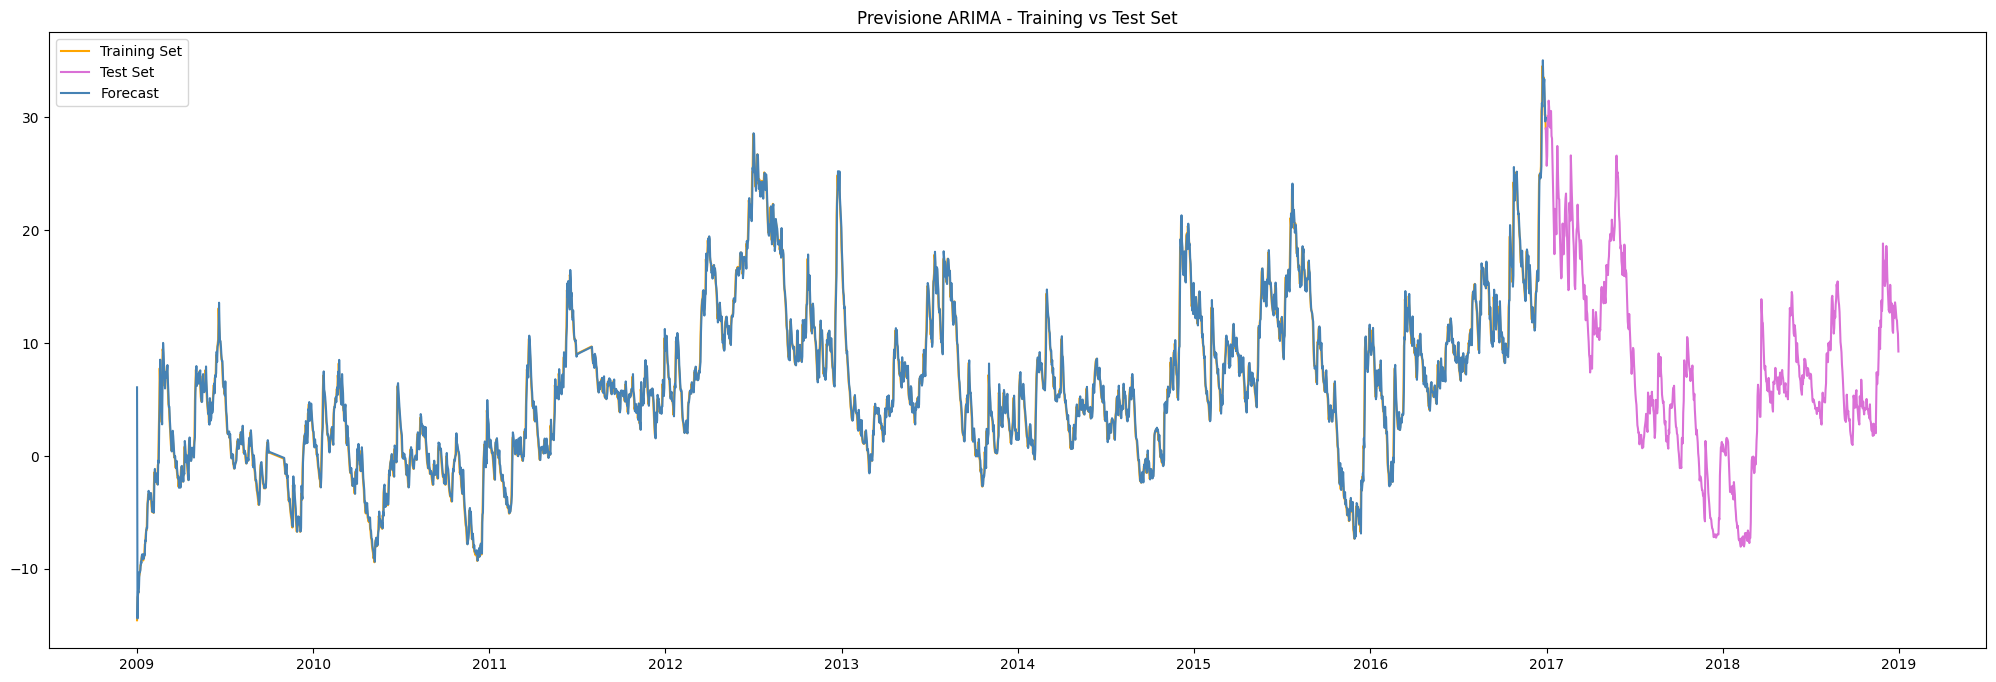

                               SARIMAX Results                                
Dep. Variable:          EMA_ARR_DELAY   No. Observations:                 2921
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3978.614
Date:                Sun, 24 Nov 2024   AIC                           7969.227
Time:                        19:03:02   BIC                           8005.105
Sample:                    01-01-2009   HQIC                          7982.150
                         - 12-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0756      1.869      3.251      0.001       2.413       9.738
ar.L1          1.6428      0.183      8.982      0.000       1.284       2.001
ar.L2         -0.6474      0.181     -3.578      0.0

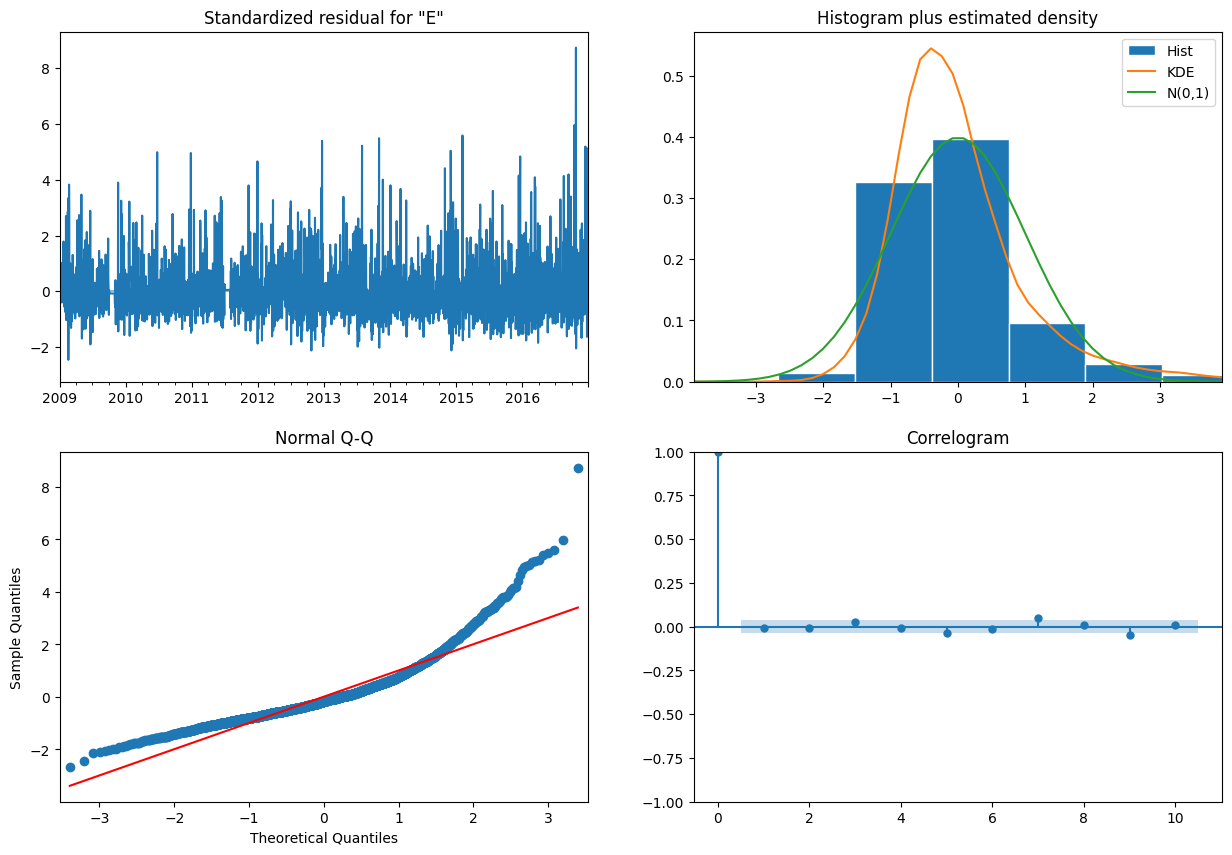

In [72]:
# Visualizzazione dei risultati
fig, ax = plt.subplots(figsize=(25, 8))

# Grafico dei dati
ax.plot(training_data, color='orange', label='Training Set')  
ax.plot(test_data, color='orchid', label='Test Set')  
ax.plot(forecast, color='steelblue', label='Forecast')  

# Aggiunta della legenda e del titolo
ax.legend(loc='upper left')
ax.set_title('Previsione ARIMA - Training vs Test Set')

# Mostra il grafico
plt.show()

# Stampa del sommario dei risultati del modello
print(model_fit.summary())

# Dettagli aggiuntivi sul periodo considerato
print(f"Numero di elementi nel periodo: {nobs}")
print(f"Indice dell'ultimo elemento del training set: {n_init_training}")

# Diagnostica dei residui
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()


### Predizione

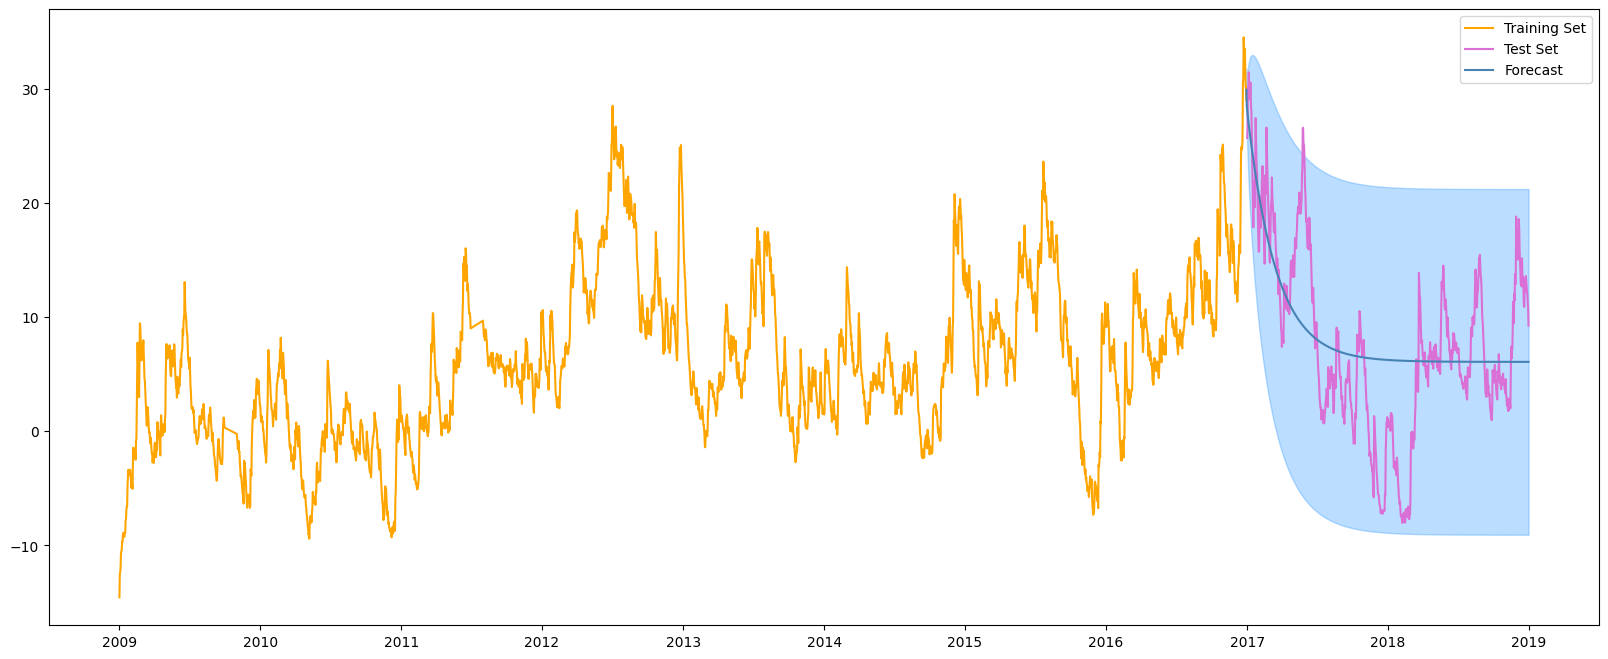

EMA_ARR_DELAY,mean,mean_se,mean_ci_lower,mean_ci_upper
2016-12-30,29.915378,0.944030,28.065113,31.765644
2016-12-31,28.482651,0.944030,26.632386,30.332917
2017-01-01,28.127936,1.460219,25.265959,30.989913
2017-01-02,27.797548,1.856322,24.159225,31.435872
2017-01-03,27.484419,2.189875,23.192343,31.776496
...,...,...,...,...
2018-12-27,6.076904,7.725531,-9.064858,21.218667
2018-12-28,6.076887,7.725531,-9.064876,21.218649
2018-12-29,6.076869,7.725531,-9.064894,21.218631
2018-12-30,6.076851,7.725531,-9.064911,21.218614


In [69]:
'''GRAFICO ARIMA'''

x = model_fit.get_prediction(
    start=test_data.index[0], 
    end=test_data.index[-1], 
).summary_frame()

# Grafico aggiornato
plt.figure(figsize=(20, 8))
plt.plot(training_data, color='orange')
plt.plot(daily_analysis_arr[n_init_training + 1:], color='orchid')
plt.plot(x['mean'], color='steelblue')
plt.legend(['Training Set', 'Test Set', 'Forecast'])
plt.fill_between(x.index, x['mean_ci_lower'], x['mean_ci_upper'], color='dodgerblue', alpha=0.3)
plt.show()

x


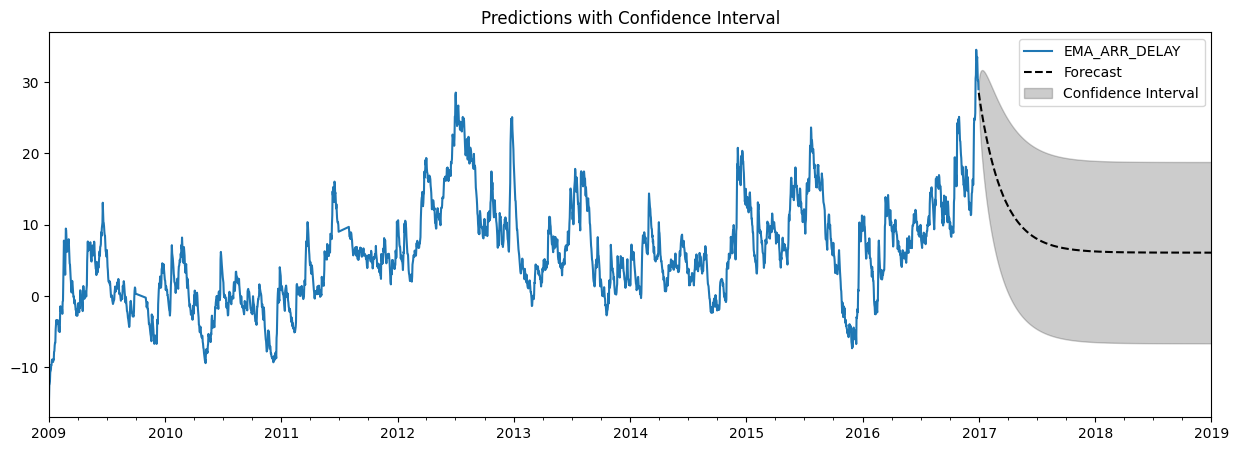

In [ ]:
'''GRAFICO ARIMA'''

forecast = model_fit.get_forecast(steps=len(test_data))
fcast = forecast.summary_frame(alpha=0.10)
forecast_idx = pd.date_range(start=training_data.index[-1] + pd.Timedelta(days=1), periods=len(test_data), freq='D')
fcast.index = forecast_idx

# Grafico
fig, ax = plt.subplots(figsize=(15, 5))
training_data[0:].plot(ax=ax)
fcast['mean'].plot(ax=ax, style='k--', label='Forecast')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("Predictions with Confidence Interval")
plt.show()


In [63]:
y_actual = daily_analysis_arr[test_data.index[0]:]
y_predicted = x['mean']

# Calculate MAPE
mape = met.mean_absolute_percentage_error(y_actual, y_predicted)
print('MAPE:', mape)

# Calculate MAE
mae = met.mean_absolute_error(y_actual, y_predicted)
print('MAE:', mae)

# Calculate SQE (Mean Squared Error)
mse = met.mean_squared_error(y_actual, y_predicted)
print('MSE:', mse)

# Calculate R2 score
r2 = met.r2_score(y_actual, y_predicted)
print('R2:', r2)


MAPE: 2.546360998466306
MAE: 4.6363507230049805
MSE: 36.42172645146757
R2: 0.44807215803630673


### Out-sample prediciton

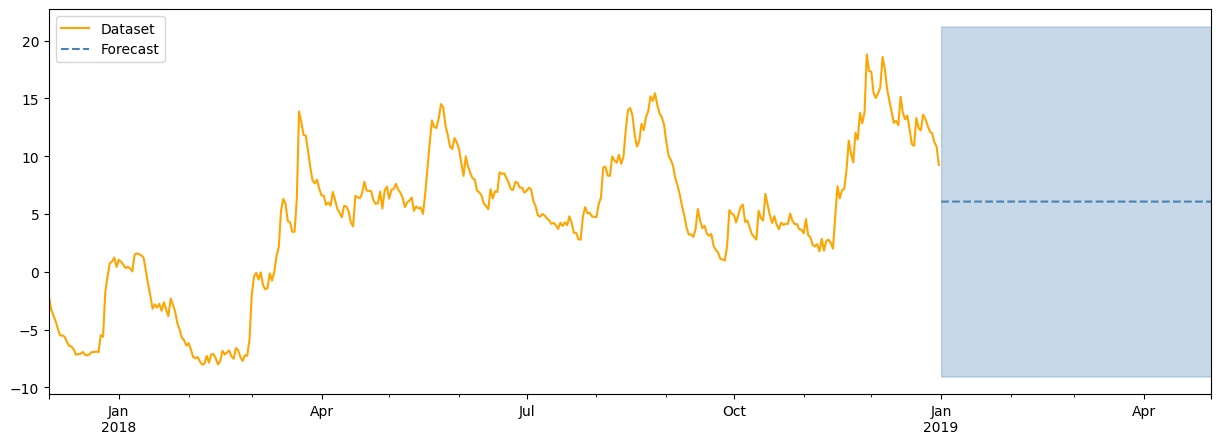

In [74]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
daily_analysis_arr['2017-12-01':].plot(ax=ax, color='orange')

# Construct the forecasts
fcast = model_fit.get_prediction(start=(nobs), end=(nobs+120)).summary_frame()
fcast['mean'].plot(ax=ax, style='--', color='steelblue')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='steelblue', alpha=0.3)
ax.legend(['Dataset', 'Forecast'])

# altro

In [18]:
nforecasts = 5
forecasts = {}

# Settiamo il numero di elementi del training set considerando di prendere l'80% dei dati a disposizione
d_len = len(y)
train = int(0.8 * len(y))  # 80% training

# Creiamo il modello per il training
init_training_y = y.iloc[:train]
mod = sm.tsa.SARIMAX(init_training_y, order=(2, 0, 0), trend='c')
res = mod.fit()

# Salviamo il forecast iniziale
forecasts[init_training_y.index[-2]] = res.forecast(steps=nforecasts)

# Andiamo avanti per i vari componenti del campione
for t in range(train, d_len):
    # aggiorniamo il risultato con l'append della nuova osservazione
    updated_y = y.iloc[t:t+1]
    res = res.append(updated_y, refit=False)
    # Salviasmo il nuovo insieme di forecasts
    forecasts[updated_y.index[0]] = res.forecast(steps=nforecasts)

# Mettiamo insieme tutti i forecasts in un dataframe
forecasts = pd.concat(forecasts, axis=1)

forecasts.iloc[:5, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
2016-12-31,9.506428,NaN,NaN,NaN,NaN
2017-01-01,9.143844,8.420121,NaN,NaN,NaN
2017-01-02,8.939971,8.568217,8.691346,NaN,NaN
2017-01-03,8.849999,8.682193,8.745441,24.640609,NaN
2017-01-04,8.807667,8.729222,8.757771,16.922612,29.448045


In [17]:
# Calcoliamo l'errore del forecast
forecast_errors = forecasts.apply(lambda column: y - column).reindex(forecasts.index)
# Re-indicizziamo i forecasts 
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

flattened.iloc[:3, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
horizon,,,,,
1,-2.161601,0.367758,47.475321,37.410673,3.768171
2,-0.355965,47.598450,53.305841,16.293604,43.115423
3,47.226696,53.369089,24.458445,49.549338,16.104567


In [19]:
# Calcoliamo lo squarto quadratico medio
rmse = (flattened**2).mean(axis=1)**0.5

rmse

horizon
1    18.615898
2    19.527456
3    19.829986
4    19.880525
5    19.888082
dtype: float64

## Departure delay

In [25]:
y = daily_analysis['AVG_DEP_DELAY']

# Costruzione del modello AR(1)
model = sm.tsa.SARIMAX(y, order=(1, 0, 0), trend='n')  # AR(1), no trend
results = model.fit()
y = y.asfreq('D')
# Stima dei parametri
results.summary()

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          AVG_DEP_DELAY   No. Observations:                 3590
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -14872.257
Date:                Sat, 23 Nov 2024   AIC                          29748.514
Time:                        10:21:05   BIC                          29760.885
Sample:                             0   HQIC                         29752.923
                               - 3590                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5875      0.010     58.040      0.000       0.568       0.607
sigma2       232.1879      3.053     76.044      0.000     226.203     238.172
===================================================================================
Ljung-Box (L1) (Q):                 233.51   Jarque-Bera (JB):              3823.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             1.33
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


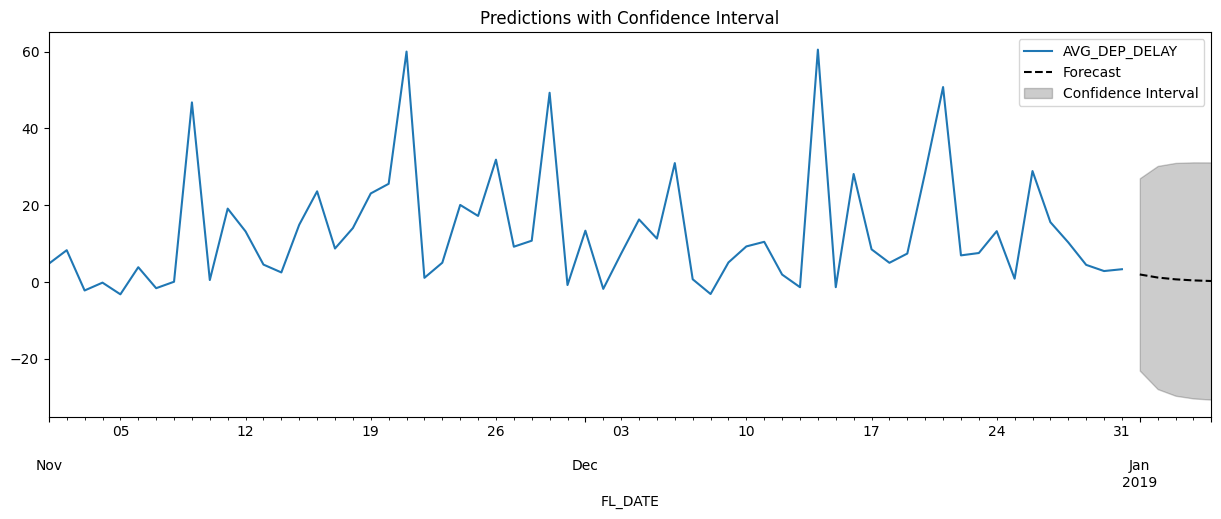

In [26]:
# Imposta una frequenza per i dati storici
y = y.asfreq('D')

# Previsioni
forecast = results.get_forecast(steps=5)
fcast = forecast.summary_frame(alpha=0.10)
forecast_idx = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')
fcast.index = forecast_idx

# Grafico
fig, ax = plt.subplots(figsize=(15, 5))
y.loc['2018-11-01':].plot(ax=ax) # Data per rendere visibile la predizione
fcast['mean'].plot(ax=ax, style='k--', label='Forecast')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("Predictions with Confidence Interval")
plt.show()


In [27]:
nforecasts = 5
forecasts = {}

# Settiamo il numero di elementi del training set considerando di prendere l'80% dei dati a disposizione
d_len = len(y)
train = int(0.8 * len(y))  # 80% training

# Creiamo il modello per il training
init_training_y = y.iloc[:train]
mod = sm.tsa.SARIMAX(init_training_y, order=(2, 0, 0), trend='c')
res = mod.fit()

# Salviamo il forecast iniziale
forecasts[init_training_y.index[-2]] = res.forecast(steps=nforecasts)

# Andiamo avanti per i vari componenti del campione
for t in range(train, d_len):
    # aggiorniamo il risultato con l'append della nuova osservazione
    updated_y = y.iloc[t:t+1]
    res = res.append(updated_y, refit=False)
    # Salviasmo il nuovo insieme di forecasts
    forecasts[updated_y.index[0]] = res.forecast(steps=nforecasts)

# Mettiamo insieme tutti i forecasts in un dataframe
forecasts = pd.concat(forecasts, axis=1)

forecasts.iloc[:5, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
2016-12-31,10.999647,NaN,NaN,NaN,NaN
2017-01-01,11.420173,9.458592,NaN,NaN,NaN
2017-01-02,11.601842,10.624396,9.667500,NaN,NaN
2017-01-03,11.682599,11.265698,10.788881,23.560678,NaN
2017-01-04,11.718190,11.532141,11.328768,17.692892,28.879903


In [28]:
# Calcoliamo l'errore del forecast
forecast_errors = forecasts.apply(lambda column: y - column).reindex(forecasts.index)
# Re-indicizziamo i forecasts 
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

flattened.iloc[:3, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
horizon,,,,,
1,-6.344475,-3.094956,41.308691,36.182912,3.336313
2,-5.056537,40.351794,48.954709,14.523325,38.386720
3,39.374348,48.477892,20.887448,43.961152,9.009478


In [29]:
# Calcoliamo lo squarto quadratico medio
rmse = (flattened**2).mean(axis=1)**0.5

rmse

horizon
1    15.000620
2    15.614679
3    15.790582
4    15.756868
5    15.697590
dtype: float64

## Flight time

In [30]:
y = daily_analysis['AVG_AIR_TIME']

# Costruzione del modello AR(1)
model = sm.tsa.SARIMAX(y, order=(1, 0, 0), trend='n')  # AR(1), no trend
results = model.fit()
y = y.asfreq('D')
# Stima dei parametri
results.summary()

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AVG_AIR_TIME   No. Observations:                 3590
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -9018.830
Date:                Sat, 23 Nov 2024   AIC                          18041.659
Time:                        10:21:55   BIC                          18054.031
Sample:                             0   HQIC                         18046.069
                               - 3590                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984      0.001   1045.548      0.000       0.997       1.000
sigma2         8.8899      0.100     88.880      0.000       8.694       9.086
===================================================================================
Ljung-Box (L1) (Q):                 369.03   Jarque-Bera (JB):              7414.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.28
Prob(H) (two-sided):                  0.80   Kurtosis:                        10.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dswal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


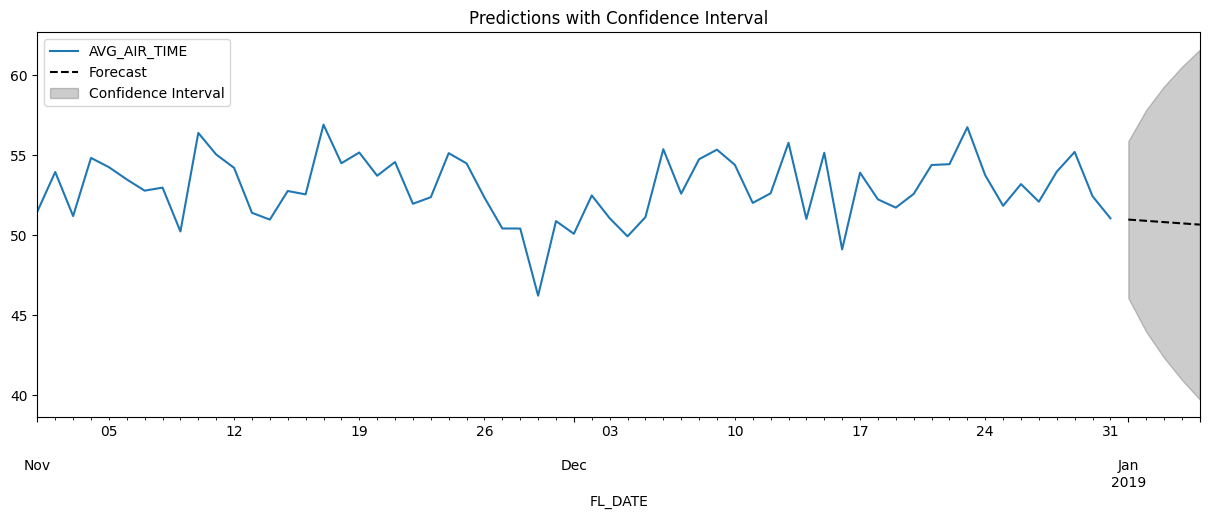

In [31]:
# Imposta una frequenza per i dati storici
y = y.asfreq('D')

# Previsioni
forecast = results.get_forecast(steps=5)
fcast = forecast.summary_frame(alpha=0.10)
forecast_idx = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=5, freq='D')
fcast.index = forecast_idx

# Grafico
fig, ax = plt.subplots(figsize=(15, 5))
y.loc['2018-11-01':].plot(ax=ax) # Data per rendere visibile la predizione
fcast['mean'].plot(ax=ax, style='k--', label='Forecast')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.title("Predictions with Confidence Interval")
plt.show()


In [32]:
nforecasts = 5
forecasts = {}

# Settiamo il numero di elementi del training set considerando di prendere l'80% dei dati a disposizione
d_len = len(y)
train = int(0.8 * len(y))  # 80% training

# Creiamo il modello per il training
init_training_y = y.iloc[:train]
mod = sm.tsa.SARIMAX(init_training_y, order=(2, 0, 0), trend='c')
res = mod.fit()

# Salviamo il forecast iniziale
forecasts[init_training_y.index[-2]] = res.forecast(steps=nforecasts)

# Andiamo avanti per i vari componenti del campione
for t in range(train, d_len):
    # aggiorniamo il risultato con l'append della nuova osservazione
    updated_y = y.iloc[t:t+1]
    res = res.append(updated_y, refit=False)
    # Salviasmo il nuovo insieme di forecasts
    forecasts[updated_y.index[0]] = res.forecast(steps=nforecasts)

# Mettiamo insieme tutti i forecasts in un dataframe
forecasts = pd.concat(forecasts, axis=1)

forecasts.iloc[:5, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
2016-12-31,55.450832,NaN,NaN,NaN,NaN
2017-01-01,54.639815,56.175242,NaN,NaN,NaN
2017-01-02,54.187567,55.053429,53.602102,NaN,NaN
2017-01-03,53.946726,54.406827,53.588391,52.493915,NaN
2017-01-04,53.817288,54.064676,53.629776,53.012576,48.263746


In [33]:
# Calcoliamo l'errore del forecast
forecast_errors = forecasts.apply(lambda column: y - column).reindex(forecasts.index)
# Re-indicizziamo i forecasts 
def flatten(column):
    return column.dropna().reset_index(drop=True)

flattened = forecast_errors.apply(flatten)
flattened.index = (flattened.index + 1).rename('horizon')

flattened.iloc[:3, :5]

,2016-12-29,2016-12-31,2017-01-01,2017-01-02,2017-01-03
horizon,,,,,
1,3.583651,-3.387363,-2.554483,-11.083658,2.601119
2,-1.851936,-4.005810,-12.178135,-2.147711,-1.456561
3,-3.139948,-12.996571,-2.764911,-4.134534,0.258781


In [23]:
# Calcoliamo lo squarto quadratico medio
rmse = (flattened**2).mean(axis=1)**0.5

rmse

horizon
1    18.615898
2    19.527456
3    19.829986
4    19.880525
5    19.888082
dtype: float64